In [552]:
import datetime as dt
import numpy as np 
import pandas as pd 
import pandas_datareader.data as web 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 
from matplotlib import style
%matplotlib inline

style.use('fivethirtyeight')

In [553]:
start = dt.datetime(2017, 1, 1)
end = dt.datetime(2017, 6, 1)

# list of stocks in portfolio
tickers = ['AAPL', 'FB', 'MSFT', 'NKE']

# Number of assets in portfolio
noa = len(tickers)

# array of weights in portfolio
weight = np.array([[0.25, 0.25, 0.25, 0.25]])

In [554]:
def get_return(tickers, start, end, log_return=True):
    '''Download the price from yahoo finance
       Calculate the log return and store them in to a dataframe
       replace NaN with 0, if any'''    
    data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']
    data = data.sort_index()    
    if log_return:
        daily_return = np.log(data.pct_change()+1)
    else:
        daily_return = data.pct_change()           
    daily_return.fillna(0, inplace=True)    
    return daily_return

In [556]:
daily_return = get_return(tickers, start, end)
daily_return.head()

,AAPL,FB,MSFT,NKE
Date,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000
2017-01-04,-0.001120,0.015538,-0.004484,0.020753
2017-01-05,0.005072,0.016544,0.000000,-0.000188
2017-01-06,0.011087,0.022453,0.008630,0.015893
2017-01-09,0.009118,0.012001,-0.003188,-0.009880


In [557]:
def rand_weights(noa):
    ''' Produces some random weights that sum to 1 '''
    w = np.random.random(noa) 
    w /= np.sum(w)
    return w

rand_weights(noa)

array([ 0.24943071,  0.27557857,  0.14757955,  0.32741117])

In [558]:
def random_portfolio(daily_return):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    P = np.asmatrix(daily_return.mean() * 252)
    W = np.asmatrix(rand_weights(noa))
    C = np.asmatrix(daily_return.cov() * 252)
    
    mu = W * P.T
    sigma = np.sqrt(W * C * W.T)
    
    return mu, sigma

In [559]:
n_portfolios = 10000

means, stds = np.column_stack([
random_portfolio(daily_return) 
    for _ in range(n_portfolios)
])

In [560]:
daily_return['Portfolio'] = daily_return.dot(weight.T)
daily_return['SPY'] = get_return('SPY', start, end)
daily_return.head()

,AAPL,FB,MSFT,NKE,Portfolio,SPY
Date,,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,-0.001120,0.015538,-0.004484,0.020753,0.007672,0.005932
2017-01-05,0.005072,0.016544,0.000000,-0.000188,0.005357,-0.000795
2017-01-06,0.011087,0.022453,0.008630,0.015893,0.014516,0.003571
2017-01-09,0.009118,0.012001,-0.003188,-0.009880,0.002013,-0.003306


In [561]:
cum_daily_return = (1 + daily_return).cumprod()
cum_daily_return.tail()

,AAPL,FB,MSFT,NKE,Portfolio,SPY
Date,,,,,,
2017-05-26,1.327102,1.296646,1.127979,1.007640,1.185813,1.076692
2017-05-30,1.327620,1.298775,1.135212,1.013943,1.190171,1.075757
2017-05-31,1.319735,1.290910,1.125984,1.015283,1.184576,1.075489
2017-06-01,1.323359,1.291506,1.130168,1.005430,1.183753,1.084008
2017-06-02,1.342826,1.309114,1.156619,1.018419,1.202890,1.087610


In [562]:
ndays = len(daily_return)
actual_return = (1 + daily_return).prod() - 1
annualized_return = (1 + actual_return) ** ( 252 / ndays ) - 1
annualized_stdev = daily_return.std() * np.sqrt(252)

results = smf.ols('Portfolio ~ SPY', data=daily_return).fit()

ra = annualized_return['Portfolio']
rm = annualized_return['SPY']
rf = 0.00 # you can change this number

beta = results.params[1]
alpha = ra - beta*(rm - rf)

sharpe_ratio = (ra-rf)/annualized_stdev['Portfolio']

In [563]:
print('Portfolio_annualized_return: ' + str(annualized_return['Portfolio']))
print('Portfolio_annualized_stdev: ' + str(annualized_stdev['Portfolio']))
print('Benchmark_annualized_return: ' + str(annualized_return['SPY']))
print('Benchmark_annualized_stdev: ' + str(annualized_stdev['SPY']))
print('Portfolio Beta: ' + str(beta))
print('Alpha: ' + str(alpha))
print('Sharpe_ratio: ' + str(sharpe_ratio))

Portfolio_annualized_return: 0.557910023127
Portfolio_annualized_stdev: 0.0982440376708
Benchmark_annualized_return: 0.223307484231
Benchmark_annualized_stdev: 0.0703911215652
Portfolio Beta: 0.880497354834
Alpha: 0.361288373947
Sharpe_ratio: 5.67881813853


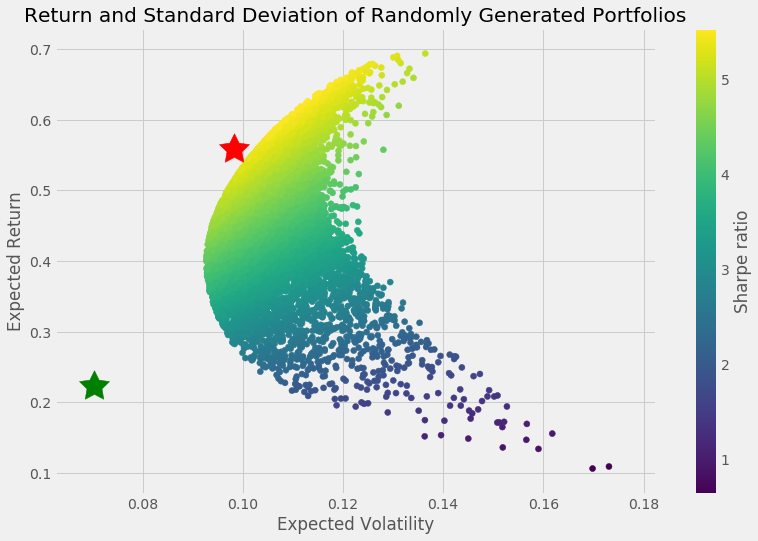

In [564]:
plt.figure(figsize=(12, 8)) 
plt.scatter(stds, means, c=means / stds, marker='o') 
plt.grid(True) 
plt.xlabel('Expected Volatility') 
plt.ylabel('Expected Return') 
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.colorbar(label='Sharpe ratio')
# this red star is our portfolio
plt.scatter(annualized_stdev['Portfolio'],annualized_return['Portfolio'],marker=(5,1,0),color='r',s=1000)
# this green star is the benchmark, SPY
plt.scatter(annualized_stdev['SPY'],annualized_return['SPY'],marker=(5,1,0),color='g',s=1000)

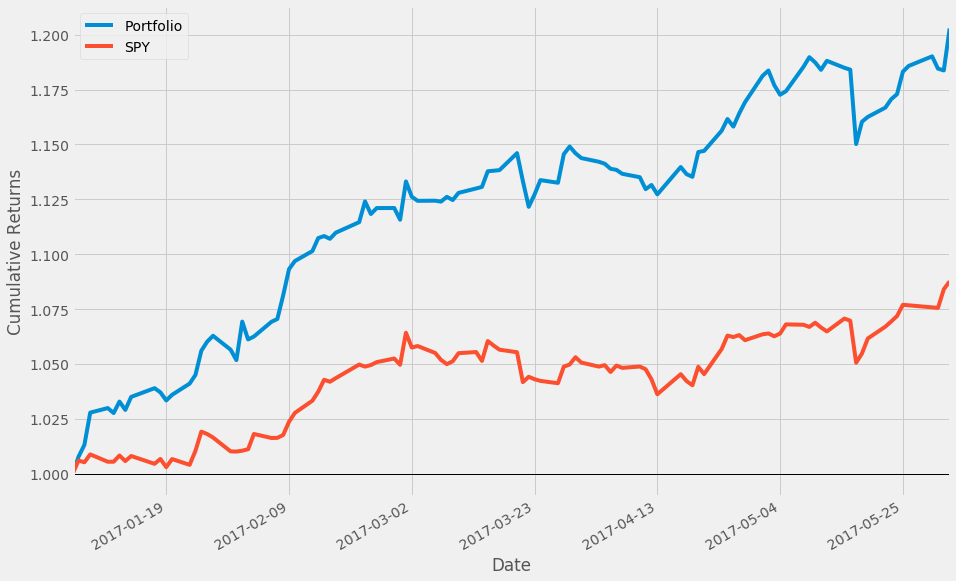

In [565]:
cum_daily_return[['Portfolio','SPY']].plot(grid = True, figsize=(14,10)).axhline(y = 1, color = "black", lw = 1)
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

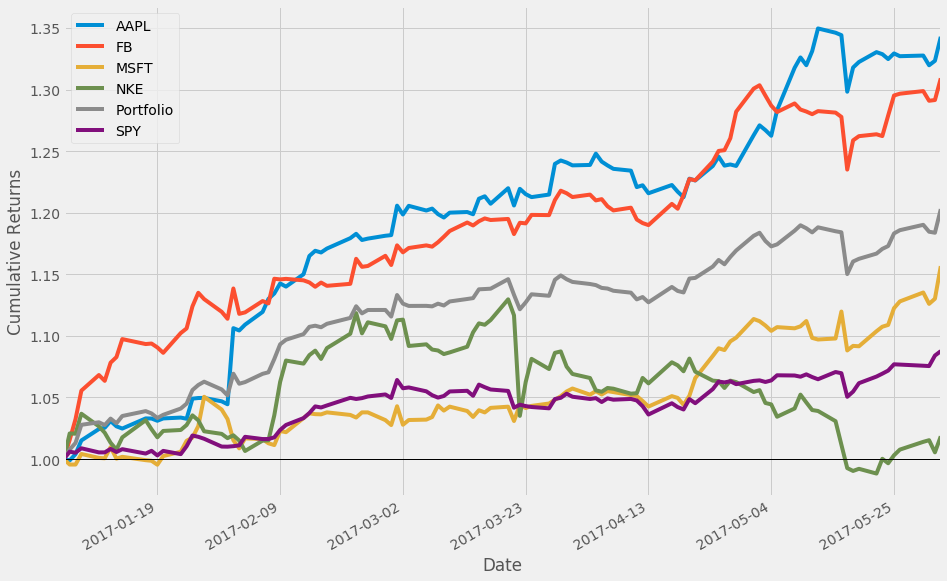

In [566]:
cum_daily_return.plot(grid = True, figsize=(14,10)).axhline(y = 1, color = "black", lw = 1)
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()